In [2]:
## point to my utils/analysis code
hbpmloc = '/mnt/c/Users/Alexander/Documents/LIGO/PM/HAYstack/'
## basic imports
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
import scipy.stats as st
import matplotlib
import matplotlib.lines as mlines
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde as kde
from scipy.stats.mstats import mquantiles as mq
from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde
from glob import glob
import pandas as pd
import sys 
import os
import pickle

## Importing the accompanying utility and analysis files
sys.path.append(os.path.abspath(hbpmloc+'hbpm_utils/'))
from hbpm_utils import *
from importlib import reload
reload(sys.modules["hbpm_utils"])
from hbpm_utils import *
sys.path.append(hbpmloc)
from hbpm_analysis import run_analysis
reload(sys.modules["hbpm_analysis"])
from hbpm_analysis import run_analysis

## my preferred figure settings
matplotlib.rcParams['figure.figsize'] = (8.08, 5.)
matplotlib.rcParams['xtick.labelsize'] = 12.0
matplotlib.rcParams['ytick.labelsize'] = 12.0
matplotlib.rcParams['axes.labelsize'] = 14.0
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["mediumorchid", "teal", "goldenrod","slategray"])

## O4/O5

In [36]:
O4O5_datapath = '/mnt/c/Users/Alexander/Documents/LIGO/PM/hbpm_paper/paper_data/monte_carlo_data/O4O5_noiseonly/'

In [74]:
## get Noah's pickle files
jar = {}
for cuke in glob(O4O5_datapath+'/pickles/O*'):
    label = cuke.replace(O4O5_datapath+'/pickles/','').replace('.pickle','').replace('File','')
    with open(cuke,'rb') as f:
        jar[label] = pickle.load(f)

In [75]:
jar.keys()

dict_keys(['O4_1', 'O4_2', 'O4_3', 'O4_4', 'O5_1', 'O5_2', 'O5_3', 'O5_4'])

In [3]:
## fine grid
fs = np.linspace(1.5,4,200)
Ms = np.linspace(0.8,1.8,200)
Rs = np.linspace(9,15,200)

In [4]:
## get the Dietrich et al. (2020) multimessenger prior for R_1.6
Rs_mm, Rprior_mm_kernel, R16samples = load_Rprior(hbpmloc+'/priors/R16_prior.txt',return_samples=True,plot=False)
Rprior_kernel = st.uniform(loc=9,scale=6)

In [78]:
## test run with O4
O4_posts = [Rs]
O5_posts = [Rs]
for contents in jar.keys():
    if 'O4' in contents:
        standin = O4_posts
    elif 'O5' in contents:
        standin = O5_posts
    else:
        raise TypeError("Formatting should either have O4 or O5 in the string key.")
    for key in jar[contents].keys():
        standin.append(get_posterior(Rs,get_aggregate_likelihood(jar[contents][key]),Rprior_kernel))

In [79]:
np.array(O4_posts).shape,np.array(O5_posts).shape

((1001, 200), (1001, 200))

In [80]:
np.savetxt(O4O5_datapath+'/O4_posts.txt',O4_posts,delimiter=',')
np.savetxt(O4O5_datapath+'/O5_posts.txt',O5_posts,delimiter=',')

In [81]:
## O4+O5
O4O5_posts = [Rs]
for O4_post, O5_post in zip(O4_posts[1:],O5_posts[1:]):
    O4O5_posts.append((O4_post*O5_post)/np.sum(O4_post*O5_post))

In [82]:
np.array(O4O5_posts).shape

(1001, 200)

In [83]:
np.savetxt(O4O5_datapath+'/O4O5_posts.txt',O4O5_posts,delimiter=',')

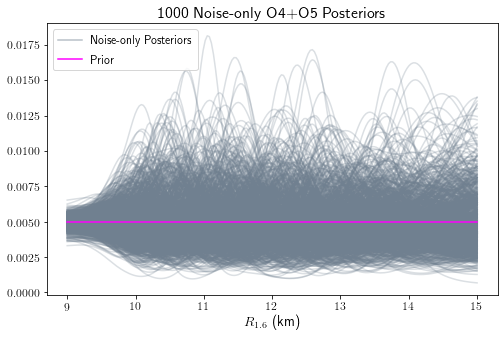

In [86]:
## take a gander, just for kicks
plt.figure()
plt.title("1000 Noise-only O4+O5 Posteriors")
plt.xlabel("$R_{1.6}$ (km)")
# plt.gca().set_yticks([])
plt.plot(Rs,np.array(O4O5_posts[1:]).T,color='slategrey',alpha=0.25,label='_nolegend_')
# for i in np.arange(0,100):
#     post_i = get_posterior(Rs,get_aggregate_likelihood(posts_ns[i]),Rprior_kernel)
#     if i==0:
#         plt.plot(Rs,post_i,color='slategrey',alpha=0.5,label='No Signal')
#     else:
#         plt.plot(Rs,post_i,color='slategrey',alpha=0.5,label='_nolegend_')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),color='magenta',label='Prior')
# plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(likes_O5_agg50),Rprior_kernel),color='cyan',label='O5 Posterior')
# plt.legend(handles=[handle],labels=['Noise-only Posteriors'])
# plt.savefig('./figures/R16_posterior_O5v100no-signal.pdf',bbox_inches='tight')
grey_line = mlines.Line2D([], [], color='slategray',alpha=0.5,label='Noise-only Posteriors')
prior_line = mlines.Line2D([], [], color='magenta',label='Prior')
plt.legend(handles=[grey_line,prior_line],loc='upper left')
plt.show()

In [87]:
## we also need to grab the final O4/O5/O4O5 posteriors and save them for Jesse
# badlist = ['./analysis/Aplus','../O4O5_sims/O5full_dd2_backup_out']
badkeys = ['eos', 'Rs', 'prior']
can = {}
for path in [file+'/posterior_eventdict.pickle' for file in glob('./paper_data/analysis/O*')]:
    with open(path,'rb') as f:
        data = pickle.load(f)
    name = path.split('/')[-2].split('_')[-1]
    can[name] = get_aggregate_likelihood([data[key]['likelihood_i'] for key in data.keys() if key not in badkeys])

In [88]:
can.keys()

dict_keys(['dd2O4', 'dd2O5', 'sfhxO4', 'sfhxO5', 'sly4O4', 'sly4O5'])

In [89]:
dd2O4 = [Rs,get_posterior(Rs,can['dd2O4'],Rprior_kernel)]
dd2O5 = [Rs,get_posterior(Rs,can['dd2O5'],Rprior_kernel)]
dd2O4O5 = [Rs,get_posterior(Rs,get_aggregate_likelihood([can['dd2O4'],can['dd2O5']]),Rprior_kernel)]

In [90]:
sly4O4 = [Rs,get_posterior(Rs,can['sly4O4'],Rprior_kernel)]
sly4O5 = [Rs,get_posterior(Rs,can['sly4O5'],Rprior_kernel)]
sly4O4O5 = [Rs,get_posterior(Rs,get_aggregate_likelihood([can['sly4O4'],can['sly4O5']]),Rprior_kernel)]

In [91]:
sfhxO4 = [Rs,get_posterior(Rs,can['sfhxO4'],Rprior_kernel)]
sfhxO5 = [Rs,get_posterior(Rs,can['sfhxO5'],Rprior_kernel)]
sfhxO4O5 = [Rs,get_posterior(Rs,get_aggregate_likelihood([can['sfhxO4'],can['sfhxO5']]),Rprior_kernel)]

In [92]:
names = ['dd2O4.txt','dd2O5.txt','dd2O4O5.txt','sly4O4.txt','sly4O5.txt','sly4O4O5.txt',
         'sfhxO4.txt','sfhxO5.txt','sfhxO4O5.txt']
lists = [dd2O4,dd2O5,dd2O4O5,sly4O4,sly4O5,sly4O4O5,sfhxO4,sfhxO5,sfhxO4O5]
for name, lst in zip(names,lists):
    np.savetxt(O4O5_datapath+name,lst,delimiter=',')

/home/alexander/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


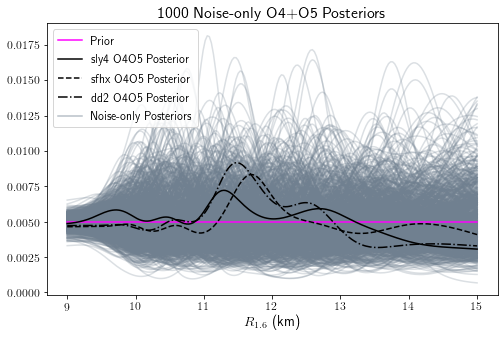

In [93]:
## take a gander, just for kicks
plt.figure()
plt.title("1000 Noise-only O4+O5 Posteriors")
plt.xlabel("$R_{1.6}$ (km)")
# plt.gca().set_yticks([])
plt.plot(Rs,np.array(O4O5_posts[1:]).T,color='slategrey',alpha=0.25,label='_nolegend_')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),color='magenta',label='Prior')
plt.plot(sly4O4O5[0],sly4O4O5[1],color='k',ls='-',label='sly4 O4O5 Posterior')
plt.plot(sfhxO4O5[0],sfhxO4O5[1],color='k',ls='--',label='sfhx O4O5 Posterior')
plt.plot(dd2O4O5[0],dd2O4O5[1],color='k',ls='-.',label='dd2 O4O5 Posterior')
grey_line = mlines.Line2D([], [], color='slategray',alpha=0.5,label='Noise-only Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[grey_line])
# plt.savefig('O4O5_example_comparison_fig.png',bbox_inches='tight')
plt.show()

## A+ 4yr

In [38]:
Aplus_datapath = '/mnt/c/Users/Alexander/Documents/LIGO/PM/hbpm_paper/paper_data/monte_carlo_data/Aplus_4yr_noiseonly/'

In [39]:
## get Noah's pickle files
Aplus_jar = {}
for cuke in glob(Aplus_datapath+'/pickles/A*'):
    label = cuke.replace(Aplus_datapath+'/pickles/','').replace('.pickle','').replace('File','').replace('Aplus_4yr_','')
    with open(cuke,'rb') as f:
        Aplus_jar[label] = pickle.load(f)

In [40]:
Aplus_jar.keys()

dict_keys(['pt1_1', 'pt1_10', 'pt1_2', 'pt1_3', 'pt1_4', 'pt1_5', 'pt1_6', 'pt1_7', 'pt1_8', 'pt1_9', 'pt2_1', 'pt2_10', 'pt2_2', 'pt2_3', 'pt2_4', 'pt2_5', 'pt2_6', 'pt2_7', 'pt2_8', 'pt2_9'])

In [41]:
pt1 = [Rs]
pt2 = [Rs]
for contents in Aplus_jar.keys():
    if 'pt1' in contents:
        standin = pt1
    elif 'pt2' in contents:
        standin = pt2
    else:
        raise TypeError("Formatting should either have pt1 or pt2 in the string key.")
    for key in Aplus_jar[contents].keys():
        standin.append(get_posterior(Rs,get_aggregate_likelihood(Aplus_jar[contents][key]),Rprior_kernel))

In [42]:
np.array(pt1).shape,np.array(pt2).shape

((1001, 200), (1001, 200))

In [43]:
## O4+O5
Aplus_posts = [Rs]
for pt1_post, pt2_post in zip(pt1[1:],pt2[1:]):
    Aplus_posts.append((pt1_post*pt2_post)/np.sum(pt1_post*pt2_post))

In [44]:
np.array(Aplus_posts).shape

(1001, 200)

In [45]:
np.savetxt(Aplus_datapath+'/Aplus_4yr_posts.txt',Aplus_posts,delimiter=',')

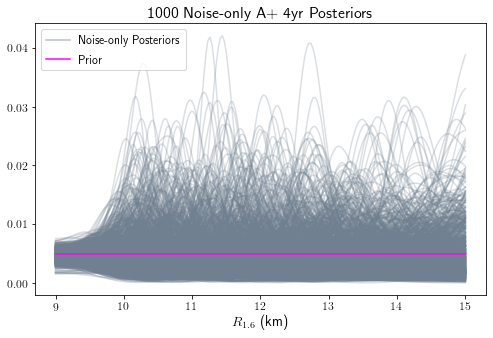

In [46]:
## take a gander, just for kicks
plt.figure()
plt.title("1000 Noise-only A+ 4yr Posteriors")
plt.xlabel("$R_{1.6}$ (km)")
# plt.gca().set_yticks([])
plt.plot(Rs,np.array(Aplus_posts[1:]).T,color='slategrey',alpha=0.25,label='_nolegend_')
# for i in np.arange(0,100):
#     post_i = get_posterior(Rs,get_aggregate_likelihood(posts_ns[i]),Rprior_kernel)
#     if i==0:
#         plt.plot(Rs,post_i,color='slategrey',alpha=0.5,label='No Signal')
#     else:
#         plt.plot(Rs,post_i,color='slategrey',alpha=0.5,label='_nolegend_')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),color='magenta',label='Prior')
# plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(likes_O5_agg50),Rprior_kernel),color='cyan',label='O5 Posterior')
# plt.legend(handles=[handle],labels=['Noise-only Posteriors'])
# plt.savefig('./figures/R16_posterior_O5v100no-signal.pdf',bbox_inches='tight')
grey_line = mlines.Line2D([], [], color='slategray',alpha=0.5,label='Noise-only Posteriors')
prior_line = mlines.Line2D([], [], color='magenta',label='Prior')
plt.legend(handles=[grey_line,prior_line],loc='upper left')
plt.show()

In [47]:
## we also need to grab the final A+ 4yr posteriors and save them for Jesse
# badlist = ['./analysis/Aplus','../O4O5_sims/O5full_dd2_backup_out']
badkeys = ['eos', 'Rs', 'prior']
Aplus_can = {}
for path in [file+'/posterior_eventdict.pickle' for file in glob('./paper_data/analysis/Aplus_4yr_HLV*')]:
    with open(path,'rb') as f:
        data = pickle.load(f)
    name = path.split('/')[-2].split('_')[-1]
    Aplus_can[name] = get_aggregate_likelihood([data[key]['likelihood_i'] for key in data.keys() if key not in badkeys])

In [48]:
Aplus_can.keys()

dict_keys(['pt1', 'pt2'])

In [49]:
Aplus_full = [Rs,get_posterior(Rs,get_aggregate_likelihood([Aplus_can['pt1'],Aplus_can['pt2']]),Rprior_kernel)]

In [50]:
np.savetxt(Aplus_datapath+'Aplus4yr.txt',Aplus_full,delimiter=',')

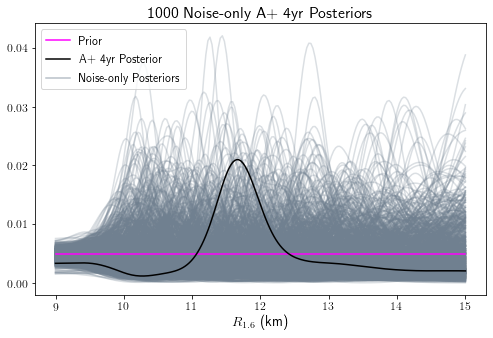

In [51]:
## take a gander, just for kicks
plt.figure()
plt.title("1000 Noise-only A+ 4yr Posteriors")
plt.xlabel("$R_{1.6}$ (km)")
# plt.gca().set_yticks([])
plt.plot(Rs,np.array(Aplus_posts[1:]).T,color='slategrey',alpha=0.25,label='_nolegend_')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),color='magenta',label='Prior')
plt.plot(Aplus_full[0],Aplus_full[1],color='k',ls='-',label='A+ 4yr Posterior')
grey_line = mlines.Line2D([], [], color='slategray',alpha=0.5,label='Noise-only Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[grey_line],loc='upper left')
# plt.savefig('O4O5_example_comparison_fig.png',bbox_inches='tight')
plt.show()

## Get O4O5 and A+ 4yr with MMA Prior

In [16]:
likes1 = []
likes2 = []
for contents in Aplus_jar.keys():
    if 'pt1' in contents:
        standin = likes1
    elif 'pt2' in contents:
        standin = likes2
    else:
        raise TypeError("Formatting should either have pt1 or pt2 in the string key.")
    for key in Aplus_jar[contents].keys():
        standin.append(get_aggregate_likelihood(Aplus_jar[contents][key]))

In [20]:
pt1 = [Rs]
pt2 = [Rs]
full = [Rs]
for like1,like2 in zip(likes1,likes2):
    pt1.append(get_posterior(Rs,like1,Rprior_mm_kernel))
    pt2.append(get_posterior(Rs,like2,Rprior_mm_kernel))
    full.append(get_posterior(Rs,get_aggregate_likelihood([like1,like2]),Rprior_mm_kernel))

In [21]:
np.array(full).shape

(1001, 200)

In [22]:
np.savetxt(Aplus_datapath+'/Aplus_4yr_posts_multimessenger.txt',full,delimiter=',')

In [23]:
## we also need to grab the final A+ 4yr posteriors and save them for Jesse
# badlist = ['./analysis/Aplus','../O4O5_sims/O5full_dd2_backup_out']
badkeys = ['eos', 'Rs', 'prior']
Aplus_can = {}
for path in [file+'/posterior_eventdict.pickle' for file in glob('./paper_data/analysis/Aplus_4yr_HLV*')]:
    with open(path,'rb') as f:
        data = pickle.load(f)
    name = path.split('/')[-2].split('_')[-1]
    Aplus_can[name] = get_aggregate_likelihood([data[key]['likelihood_i'] for key in data.keys() if key not in badkeys])

In [24]:
Aplus_can.keys()

dict_keys(['pt1', 'pt2'])

In [25]:
Aplus_full = [Rs,get_posterior(Rs,get_aggregate_likelihood([Aplus_can['pt1'],Aplus_can['pt2']]),Rprior_mm_kernel)]

In [26]:
np.savetxt(Aplus_datapath+'Aplus4yr_multimessenger.txt',Aplus_full,delimiter=',')

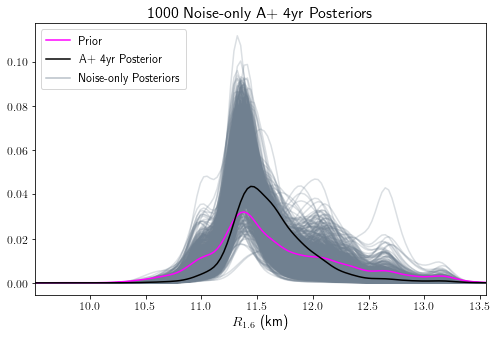

In [30]:
## take a gander, just for kicks
plt.figure()
plt.title("1000 Noise-only A+ 4yr Posteriors")
plt.xlabel("$R_{1.6}$ (km)")
# plt.gca().set_yticks([])
plt.plot(Rs,np.array(Aplus_posts[1:]).T,color='slategrey',alpha=0.25,label='_nolegend_')
plt.plot(Rs,Rprior_mm_kernel.pdf(Rs)/np.sum(Rprior_mm_kernel.pdf(Rs)),color='magenta',label='Prior')
plt.plot(Aplus_full[0],Aplus_full[1],color='k',ls='-',label='A+ 4yr Posterior')
grey_line = mlines.Line2D([], [], color='slategray',alpha=0.5,label='Noise-only Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[grey_line],loc='upper left')
plt.xlim(Rs_mm.min(),Rs_mm.max())
# plt.savefig('O4O5_example_comparison_fig.png',bbox_inches='tight')
plt.show()

In [31]:
## we also need to grab the final O4/O5/O4O5 posteriors and save them for Jesse
# badlist = ['./analysis/Aplus','../O4O5_sims/O5full_dd2_backup_out']
badkeys = ['eos', 'Rs', 'prior']
can = {}
for path in [file+'/posterior_eventdict.pickle' for file in glob('./paper_data/analysis/O*')]:
    with open(path,'rb') as f:
        data = pickle.load(f)
    name = path.split('/')[-2].split('_')[-1]
    can[name] = get_aggregate_likelihood([data[key]['likelihood_i'] for key in data.keys() if key not in badkeys])

In [32]:
dd2O4O5 = [Rs,get_posterior(Rs,get_aggregate_likelihood([can['dd2O4'],can['dd2O5']]),Rprior_mm_kernel)]

In [33]:
sly4O4O5 = [Rs,get_posterior(Rs,get_aggregate_likelihood([can['sly4O4'],can['sly4O5']]),Rprior_mm_kernel)]

In [34]:
sfhxO4O5 = [Rs,get_posterior(Rs,get_aggregate_likelihood([can['sfhxO4'],can['sfhxO5']]),Rprior_mm_kernel)]

In [37]:
names = ['dd2O4O5_multimessenger.txt','sly4O4O5_multimessenger.txt','sfhxO4O5_multimessenger.txt']
lists = [dd2O4O5,sly4O4O5,sfhxO4O5]
for name, lst in zip(names,lists):
    np.savetxt(O4O5_datapath+name,lst,delimiter=',')

In [53]:
## get Noah's pickle files
jar = {}
for cuke in glob(O4O5_datapath+'/pickles/O*'):
    label = cuke.replace(O4O5_datapath+'/pickles/','').replace('.pickle','').replace('File','')
    with open(cuke,'rb') as f:
        jar[label] = pickle.load(f)

In [54]:
likesO4 = []
likesO5 = []
for contents in jar.keys():
    if 'O4' in contents:
        standin = likesO4
    elif 'O5' in contents:
        standin = likesO5
    else:
        raise TypeError("Formatting should either have pt1 or pt2 in the string key.")
    for key in jar[contents].keys():
        standin.append(get_aggregate_likelihood(jar[contents][key]))

In [55]:
O4_posts = [Rs]
O5_posts = [Rs]
O4O5_posts = [Rs]
for like1,like2 in zip(likesO4,likesO5):
    O4_posts.append(get_posterior(Rs,like1,Rprior_mm_kernel))
    O5_posts.append(get_posterior(Rs,like2,Rprior_mm_kernel))
    O4O5_posts.append(get_posterior(Rs,get_aggregate_likelihood([like1,like2]),Rprior_mm_kernel))

In [56]:
np.array(O4_posts).shape,np.array(O5_posts).shape

((1001, 200), (1001, 200))

In [57]:
np.array(O4O5_posts).shape

(1001, 200)

In [58]:
np.savetxt(O4O5_datapath+'/O4O5_posts_multimessenger.txt',O4O5_posts,delimiter=',')